# Introduction

# MP3 & AAC

In [6]:
!ffmpeg -y -i piano.wav piano.mp3 2> /dev/null
!ffmpeg -y -i piano.wav piano.aac 2> /dev/null
!ffmpeg -y -i piano.mp3 piano_regenerated_mp3.wav 2> /dev/null
!ffmpeg -y -i piano.aac piano_regenerated_aac.wav 2> /dev/null

In [4]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from ipywidgets import widgets, Layout

def wave_specgram(wav_file, title, duration=None):    
    data, rate = sf.read(wav_file)
    if duration:
        data = data[:rate*duration]    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.specgram(data, cmap=plt.cm.gist_heat, Fs=rate)
    
    widget = widgets.Output()
    with widget:
        display(Audio(wav_file))
    return widget

def calc_ratio(original_file, other_file):
    original_file_size = os.path.getsize(original_file)
    other_file_size = os.path.getsize(other_file)
    return round(other_file_size*100/original_file_size, 2)

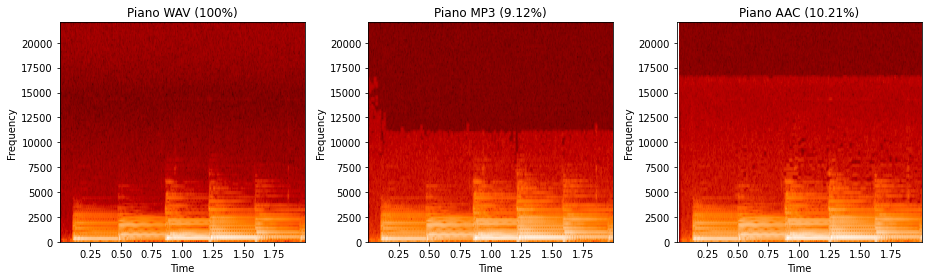

In [5]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("piano.wav", "Piano WAV (100%)", duration=2)
plt.subplot(1, 3, 2)
w2 = wave_specgram("piano_regenerated_mp3.wav", f"Piano MP3 ({calc_ratio('piano.wav','piano.mp3')}%)", duration=2)
plt.subplot(1, 3, 3)
w3 = wave_specgram("piano_regenerated_aac.wav", f"Piano AAC ({calc_ratio('piano.wav','piano.aac')}%)", duration=2)
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

In [25]:
!ffmpeg -y -i voice.wav voice.mp3 2> /dev/null
!ffmpeg -y -i voice.wav voice.aac 2> /dev/null
!ffmpeg -y -i voice.mp3 voice_regenerated_mp3.wav 2> /dev/null
!ffmpeg -y -i voice.aac voice_regenerated_aac.wav 2> /dev/null

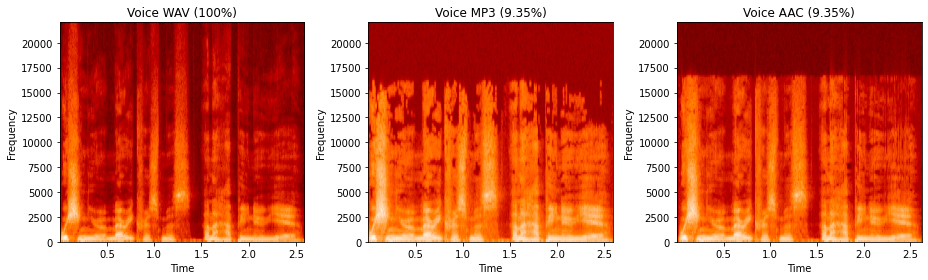

In [6]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("voice.wav", "Voice WAV (100%)")
plt.subplot(1, 3, 2)
w2 = wave_specgram("voice_regenerated_mp3.wav", f"Voice MP3 ({calc_ratio('voice.wav','voice.mp3')}%)")
plt.subplot(1, 3, 3)
w3 = wave_specgram("voice_regenerated_aac.wav", f"Voice AAC ({calc_ratio('voice.wav','voice.mp3')}%)")
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

# MDCT

# Encoder

In [7]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import mdct

def draw_mdct_spectogram(data, rate, duration, title):
    data = data[:,:rate*duration//512]
    data = np.float64(data)
    eps = 1e-10
    data = np.log(eps + data ** 2)
    data = np.flipud(data)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency Index')
    plt.imshow(data, aspect='auto', extent=[0,duration,0,512], cmap=plt.cm.gist_heat)  

def encode(input_wav_file, output_npz_name):
    data, rate = sf.read(input_wav_file)
    plt.figure(figsize=(13,4))
    
    r = mdct.mdct(data)
    np.savez_compressed(f'{output_npz_name}0.npz', rate=rate, data=r)
    plt.subplot(1, 5, 1)
    draw_mdct_spectogram(r, rate, 2, 'Original (100%)')

    r[150:511, :] = 0
    np.savez_compressed(f'{output_npz_name}1.npz', rate=rate, data=r)
    plt.subplot(1, 5, 2)
    draw_mdct_spectogram(r, rate, 2, f'High Freq Cut ({calc_ratio(input_wav_file,f"{output_npz_name}1.npz")}%)')
    
    r = np.float16(r)
    np.savez_compressed(f'{output_npz_name}2.npz', rate=rate, data=r)
    plt.subplot(1, 5, 3)
    draw_mdct_spectogram(r, rate, 2, f'Float16 ({calc_ratio(input_wav_file,f"{output_npz_name}2.npz")}%)')

    r = np.round(r, decimals=2)
    np.savez_compressed(f'{output_npz_name}3.npz', rate=rate, data=r)
    plt.subplot(1, 5, 4)
    draw_mdct_spectogram(r, rate, 2, f'Round Floats ({calc_ratio(input_wav_file,f"{output_npz_name}3.npz")}%)')

    r = np.where(abs(r) < 0.1, 0, r)
    np.savez_compressed(f'{output_npz_name}4.npz', rate=rate, data=r)
    plt.subplot(1, 5, 5)
    draw_mdct_spectogram(r, rate, 2, f'Remove Low Intensities ({calc_ratio(input_wav_file,f"{output_npz_name}4.npz")}%)')
    
    plt.tight_layout()
    plt.show()

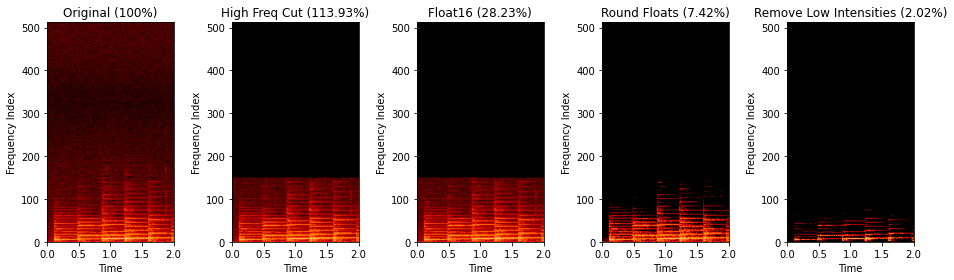

In [8]:
encode('piano.wav', 'piano_npz')

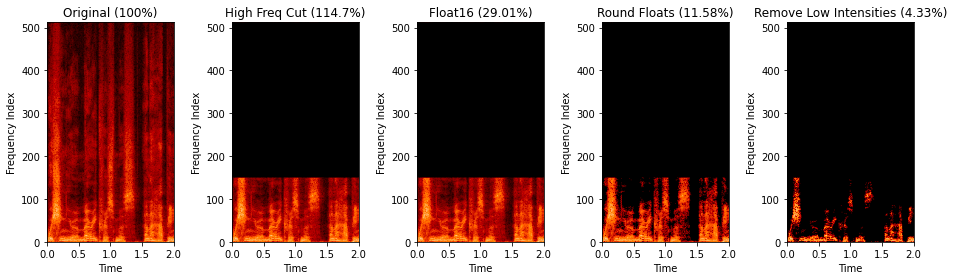

In [9]:
encode('voice.wav', 'voice_npz')

# Decoder

In [10]:
def decode(input_npz_file, output_wav_file):
    npz = np.load(input_npz_file)
    rate = npz['rate']
    sig2 = mdct.imdct(npz['data'])
    sf.write(output_wav_file, sig2, rate)

/home/matin/git/DirectedStudy/venv/lib/python3.10/site-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/home/matin/git/DirectedStudy/venv/lib/python3.10/site-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/home/matin/git/DirectedStudy/venv/lib64/python3.10/site-packages/matplotlib/axes/_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


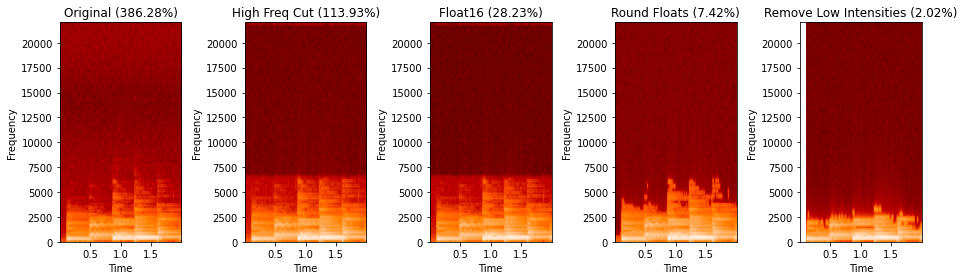

In [11]:
plt.figure(figsize=(13,4))
stages = ['Original', 'High Freq Cut', 'Float16', 'Round Floats', 'Remove Low Intensities']
audio_widgets = []

for i in range(len(stages)):
    plt.subplot(1, len(stages), i+1)
    decode(f'piano_npz{i}.npz', f'piano_regenerated_npz{i}.wav')
    widget = wave_specgram(f'piano_regenerated_npz{i}.wav', f"{stages[i]} ({calc_ratio('piano.wav',f'piano_npz{i}.npz')}%)", duration=2)
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)

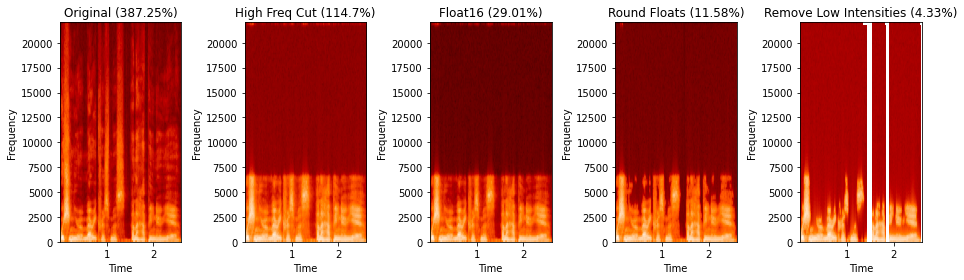

In [12]:
plt.figure(figsize=(13,4))
stages = ['Original', 'High Freq Cut', 'Float16', 'Round Floats', 'Remove Low Intensities']
audio_widgets = []

for i in range(len(stages)):
    plt.subplot(1, len(stages), i+1)
    decode(f'voice_npz{i}.npz', f'voice_regenerated_npz{i}.wav')
    widget = wave_specgram(f'voice_regenerated_npz{i}.wav', f"{stages[i]} ({calc_ratio('voice.wav',f'voice_npz{i}.npz')}%)")
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)